6.5411984053799594


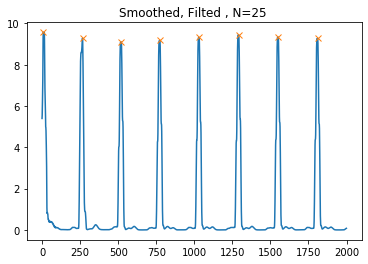

21.521404143977236


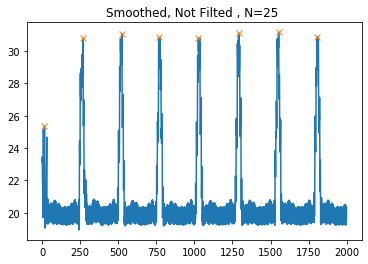

In [53]:
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import find_peaks


data = pd.read_csv('dataN.txt', header = None)

def NotchFilter(data):
    fs = 256.0  # Sample frequency (Hz)
    f0 = 50.0  # Frequency to be removed from signal (Hz)
    Q =  30  # Quality factor
    w0 = f0 / (fs / 2 )  # Normalized Frequency
    b, a = signal.iirnotch(f0,Q,fs )
    data = signal.filtfilt(b, a, data,axis=0)
    return data


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(1, [low, high], btype='band')
    return b, a
def Bandpass(data):
    b, a = butter_bandpass(0.1, 45, 256)
    y = signal.filtfilt(b, a, data,axis=0)
    return y
#plt.figure(figsize=(15,10)) 

def Filter(data):
    NotchFiltered=NotchFilter(data);
    BandFiltered=Bandpass(NotchFiltered);
    return BandFiltered;

'''
plt.plot(data[0:2000])
plt.show()
#NotchFiltered=NotchFilter(data);

#plt.plot(NotchFiltered[0:2000])
#plt.show()

#BandFiltered=Bandpass(NotchFiltered);
#print(data)
BandFiltered=Filter(data)
plt.plot(BandFiltered[0:2000])
plt.show()
'''



def differentiate(BandFiltered):
    NewArray =np.copy(BandFiltered)
    for i in range(4, len(BandFiltered)-2):
        #print(NewArray[i])
        NewArray[i]=(-1*BandFiltered[i-2]-2*BandFiltered[i-1]+1*BandFiltered[i+2]+2*BandFiltered[i+1])
    return NewArray

def Square(differentiated):
    return np.square(differentiated)


def SmoothWithWindow(data,Window=25):
    Filtered=Filter(data)
    Filtered=differentiate(Filtered)
    squared=Square(Filtered)
    NewArray =np.copy(squared)
    for i in range(0,len(squared)):
        NewArray[i]=0
        for j in range(0,Window):
            NewArray[i]+=squared[i-j]
    return NewArray

    
def SkipFilter(data,Window=25):
    Filtered=differentiate(data)
    squared=Square(Filtered)
    NewArray =np.copy(squared)
    for i in range(0,len(squared)):
        NewArray[i]=0
        for j in range(0,Window):
            NewArray[i]+=squared[i-j]
    return NewArray
    

'''        
plt.xlabel('Samples')
plt.ylabel('Voltage')
 
smoothed=SmoothWithWindow(squared,Window=5)
plt.plot(smoothed[0:2000])
plt.title('Smoothed Signal with N = 5')
plt.xlabel('Samples')
plt.ylabel('Voltage')
 

plt.show()
plt.xlabel('Samples')
plt.ylabel('Voltage')
 
smoothed=SmoothWithWindow(squared,Window=15)
plt.plot(smoothed[0:2000])
plt.title('Smoothed Signal with N = 15')

plt.show()
plt.xlabel('Samples')
plt.ylabel('Voltage')
'''


def Plot(smoothed,title,Window=25):
    ThresholdRpeak=(0.75-(1/15))*np.max(smoothed)
    print(ThresholdRpeak)
    peaks, _ = find_peaks(smoothed[0:2000].flatten(),height=ThresholdRpeak, distance=200)
    plt.plot(smoothed[0:2000])
    plt.plot(peaks, smoothed[peaks], "x")
    plt.title(title)
    plt.show()
    
smoothed=SmoothWithWindow(data,Window=25)
Plot(smoothed,"Smoothed, Filted , N=25 ")
      


SkipFilter =SkipFilter(data[0])
Plot(SkipFilter,"Smoothed, Not Filted , N=25 ")




